In [5]:
import numpy as np
import pandas as pd
import math
import collections

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeRegressor
import scipy.stats as sstat

import matplotlib.pyplot as plt

In [7]:
class xBartNode:
    def __init__(self, depth: int, obs_index: np.ndarray):
        self.depth = depth
        self.obs_index = obs_index
        self.rule = self.left = self.right = None
    
    def is_leaf(self):
        return self.left is None or self.right is None
        
    def set_rule(self, col, val):
        self.rule = (col, val)
    
    def split_by_rule(self, x: np.ndarray, index: np.ndarray):
        xj = x[:, self.rule[0]]
        index_filter = xj <= self.rule[1]
        return index[index_filter], index[~index_filter]

class xBart:
    def __init__(self, X: pd.DataFrame, Y: pd.Series, n_tree: int, nu: float, ig_q: float, max_depth: int = 20):
        self.X = X.to_numpy()
        self.Y = Y.to_numpy()
        self.nObs, self.nAdj = X.shape
        self.n_tree = n_tree
        
        self.max_depth = max_depth
        self.min_bound_nObs = 10
        
        #prior 계산
        L = 0.25*math.log(self.nObs)**math.log(math.log(self.nObs))
        self.alpha = 0.95
        self.beta = 1.25
        self.tau = 0.3*Y.var()/L
        
        self.empirical_err_var = self.estimate_error_var()
        
        self.prior_mu = Y.mean()/n_tree
        self.prior_nu, self.prior_lambda = self.estimate_sigma_prior(nu, ig_q)
    
    def get_metric(self, x: np.ndarray, y: np.ndarray, depth: int, max_cut: int):
        N, p = x.shape
        skip_filter = np.linspace(0, N-1, min(max_cut, N-1), endpoint=False, dtype=int)

        N_left = skip_filter+1
        term_left = self.sig_sq + self.tau*N_left; term_right = self.sig_sq + self.tau*(N-N_left)
        term3 = 2*math.log(self.sig_sq)-np.log(term_left)-np.log(term_right)

        total_sum_y = y.sum()

        kappa_d = math.log1p(-self.alpha*(1+depth)**(-self.beta))-(math.log(self.alpha)-self.beta*math.log(1+depth))
        null_split_lik = 0.5*(math.log(self.sig_sq)-math.log(self.sig_sq+self.tau*N)+\
            (self.tau/self.sig_sq*(total_sum_y**2)/(self.sig_sq+self.tau*N)))+kappa_d

        scores = [pd.DataFrame({
                'col': [None],
                'val': [None],
                'lik': [null_split_lik]
            })]

        for j in range(p):
            xj = x[:, j]

            order = np.argsort(xj)
            y_sorted = y[order]
            x_sorted = xj[order]

            cumsum_y = np.cumsum(y_sorted[:-1])
            sum_filter_y = cumsum_y[skip_filter]

            sum_left = sum_filter_y**2
            sum_right = (total_sum_y - sum_filter_y)**2

            #lik = term3*np.exp(
            #    (0.5*self.tau/self.sig_sq)*(sum_left/term_left + sum_right/term_right)
            #)
            
            lik = 0.5*(term3+(self.tau/self.sig_sq)*(sum_left/term_left + sum_right/term_right))
            
            scores.append(pd.DataFrame({
                'col': j,
                'val': x_sorted[skip_filter],
                'lik': lik
            }))

        return pd.concat(scores, axis=0).reset_index(drop=True)
    
    def draw_node_mu(self, residual: np.ndarray):
        post_var = 1/(len(residual)/self.sig_sq+1/self.tau)
        post_mean = post_var*(residual.sum()/self.sig_sq+self.prior_mu/self.tau)
        return np.random.normal(post_mean, math.sqrt(post_var))
    
    def draw_sigma(self, residual: np.ndarray):
        post_a = 0.5*(self.prior_nu+len(residual))
        post_b = 0.5*(self.prior_nu*self.prior_lambda+np.sum(residual**2))
        return sstat.invgamma.rvs(a=post_a, scale=post_b, size=1).item()
    
    def draw_tree(self, residual: np.ndarray):
        root = xBartNode(0, np.arange(len(self.Y)))
        bfs = collections.deque()
        bfs.append(root)
        
        leaves = []
        while bfs:
            node = bfs.popleft()
            
            if len(node.obs_index) <= self.min_bound_nObs or node.depth >= self.max_depth:
                leaves.append(node)
                continue
            
            sub_x = self.X[node.obs_index, :]
            metric = self.get_metric(sub_x, residual[node.obs_index], node.depth, 5)
            
            log_lik = metric['lik'].to_numpy()
            log_lik = np.exp(log_lik-log_lik.max())
            prob = log_lik / log_lik.sum()
            
            selected_rule = metric.iloc[np.random.choice(len(metric), 1, p=prob), :2]
            if selected_rule['col'].isna().item():
                leaves.append(node)
                continue
            
            node.set_rule(selected_rule['col'].item(), selected_rule['val'].item())
            left_obs, right_obs = node.split_by_rule(sub_x, node.obs_index)
            
            delattr(node, 'obs_index')
            
            node.left = xBartNode(node.depth+1, left_obs)
            node.right = xBartNode(node.depth+1, right_obs)
            
            bfs.append(node.left)
            bfs.append(node.right)
        
        r_hat = np.zeros_like(residual, dtype=float)
        for leaf in leaves:
            leaf.mu = self.draw_node_mu(residual[leaf.obs_index])
            r_hat[leaf.obs_index] = leaf.mu
            delattr(leaf, 'obs_index')
        
        return (root, r_hat)
    
    def estimate_error_var(self):
        tree = DecisionTreeRegressor(max_depth=5)
        tree.fit(self.X, self.Y)
        return np.var(self.Y-tree.predict(self.X))
    
    def estimate_sigma_prior(self, nu: float, q: float):
        shape = nu / 2
        qig = sstat.invgamma.ppf(q, a=shape, scale=1.0)
        lam = (2 / nu) * self.empirical_err_var / qig

        return nu, lam
    
    def init_xbart(self):
        whole_index = np.arange(self.nObs)
        null_residual = np.array([], dtype=float)
        
        self.sig_sq = self.draw_sigma(np.array([]))
        
        self.partial_fit = np.zeros((self.nObs, self.n_tree))
        self.forest = []
        for i in range(self.n_tree):
            tree = xBartNode(0, whole_index)
            tree.mu = self.draw_node_mu(null_residual)
            self.partial_fit[:, i] = tree.mu
            self.forest.append(tree)
        
        self.residual = self.Y - self.partial_fit.sum(axis=1)
    
    def mcmc_tree_step(self):
        for m in range(self.n_tree):
            self.residual += self.partial_fit[:, m]
            m_tree, m_r_hat = self.draw_tree(self.residual)
            
            self.partial_fit[:, m] = m_r_hat
            self.residual -= m_r_hat
            self.forest[m] = m_tree
    
    def burn_in(self, n_mcmc: int):
        for it in range(n_mcmc):
            self.mcmc_tree_step()
            self.sig_sq = self.draw_sigma(self.residual)
    
    def mcmc(self, n_mcmc: int):
        pred_chain = np.zeros((n_mcmc, self.nObs))
        sigma_chain = np.zeros(n_mcmc)
        
        for it in range(n_mcmc):
            self.mcmc_tree_step()
            self.sig_sq = self.draw_sigma(self.residual)
            
            pred_chain[it, :] = self.Y - self.residual
            sigma_chain[it] = self.sig_sq
        
        return pred_chain, sigma_chain
        
        

In [6]:
iris_data = load_iris()
Xpd = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
Ypd = pd.Series(np.random.normal(iris_data.target, 0.5))

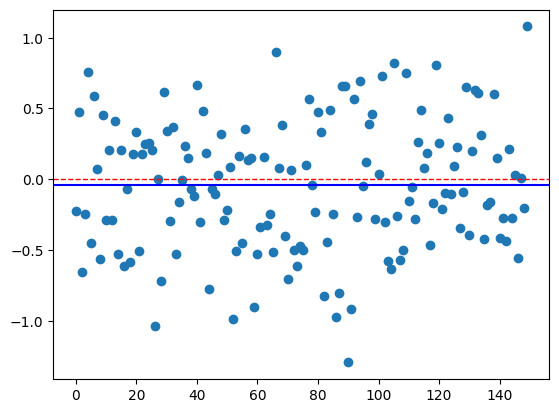

In [26]:
xb = xBart(Xpd, Ypd, 50, 3, 0.9, 5)
xb.init_xbart()
xb.burn_in(10)

plt.scatter(np.arange(len(xb.residual)), xb.residual)
plt.axline((0,xb.residual.mean()),slope=0, color='blue')
plt.axline((0,0),slope=0, color='red', linestyle='--', linewidth=1);

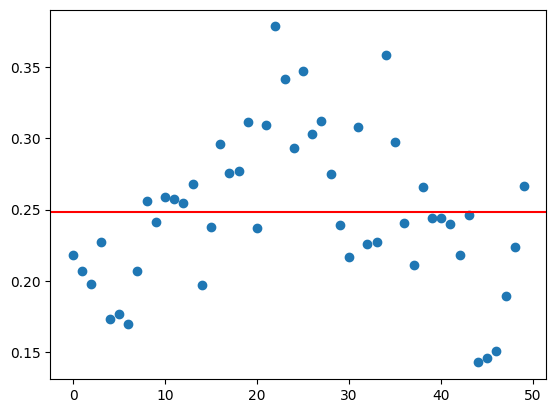

In [27]:
pred, sigma = xb.mcmc(50)
plt.scatter(np.arange(len(sigma)), sigma)
plt.axline((0,sigma.mean()),slope=0, color='red');

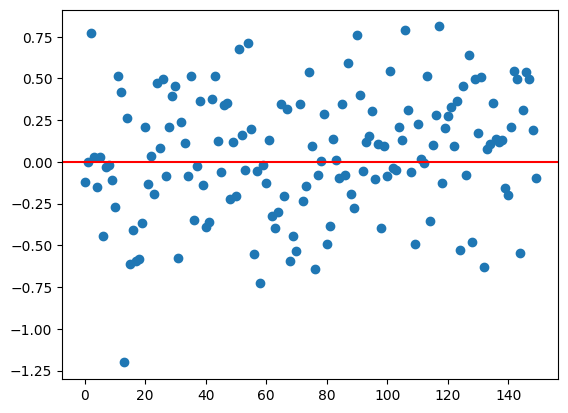

In [ ]:
plt.scatter(np.arange(len(xb.residual)), iris_data.target-pred.mean(axis=0))
plt.axline((0,0),slope=0, color='red');

### xDBART

In [13]:
def posterior_pdf(x_grid, mu, sigma2, pi):
    x = x_grid[None, None, :]        # (1,1,n_x)
    mu_exp = mu[:, :, None]          # (T,K,1)
    sigma_exp = np.sqrt(sigma2)[:, :, None]

    comp_pdf = sstat.norm.pdf(x, loc=mu_exp, scale=sigma_exp)  # (T,K,n_x)
    mix_pdf = np.sum(pi[:, :, None] * comp_pdf, axis=1)  # (T,n_x)

    return mix_pdf

In [16]:
class xBartDiric(xBart):
    def __init__(self, X: pd.DataFrame, Y: pd.Series, n_tree: int, dpm_tau_proportion=0.1, dpm_cluster_err_ig_a=2):
        super().__init__(X, Y, n_tree, 3, 0.9)
        
        self.dpm_k = 30
        self.dpm_alpha = 0.5
        
        self.dpm_prior_mu0 = 0
        self.dpm_prior_tau2 = self.empirical_err_var*dpm_tau_proportion
        
        self.dpm_prior_sigma_a = dpm_cluster_err_ig_a
        self.dpm_prior_sigma_b = (1-dpm_tau_proportion)*(self.dpm_prior_sigma_a-1)*self.empirical_err_var
    
    def init_xbart(self):
        super().init_xbart()
        
        null_data = np.array([], dtype=int)
        self.dpm_rv_pi, Z = self.draw_dpm_pi(null_data)
        self.dpm_rv_sigma2 = sstat.invgamma.rvs(a=self.dpm_prior_sigma_a, scale=self.dpm_prior_sigma_b, size=self.dpm_k)
        self.dpm_rv_mu = np.random.normal(0, self.dpm_prior_tau2, self.dpm_k)
        
    def get_metric(self, x: np.ndarray, y: np.ndarray, depth: int, max_cut: int):
        N, p = x.shape
        skip_filter = np.linspace(0, N-1, min(max_cut, N-1), endpoint=False, dtype=int)

        Z_latent = self.dpm_estimate_Z(y)
        
        y_adj = y - self.dpm_rv_mu[Z_latent]
        sigma2_inv = 1/self.dpm_rv_sigma2[Z_latent]
        sigma2_inv_sum = sigma2_inv.sum()

        y_sigma = y_adj*sigma2_inv
        y_sigma_sum = y_sigma.sum()

        kappa_d = math.log1p(-self.alpha*(1+depth)**(-self.beta))-(math.log(self.alpha)-self.beta*math.log(1+depth))
        
        term_left = 1+self.tau*sigma2_inv_sum
        term_1 = np.log(term_left)
        term_2 = self.tau/term_left*y_sigma_sum**2
        
        null_split_lik = 0.5*(-term_1+term_2)+kappa_d

        scores = [pd.DataFrame({
                'col': [None],
                'val': [None],
                'lik': [null_split_lik]
            })]

        for j in range(p):
            xj = x[:, j]

            order = np.argsort(xj)
            y_sigma_cusum = y_sigma[order].cumsum()[:-1][skip_filter]
            sigma2_inv_cusum = sigma2_inv[order].cumsum()[:-1][skip_filter]
            x_sorted = xj[order]
            
            term_left = 1+self.tau*sigma2_inv_cusum; term_right = 1+self.tau*(sigma2_inv_sum-sigma2_inv_cusum)
            term_1 = np.log(term_left)+np.log(term_right)
            term_2 = self.tau*((y_sigma_cusum**2)/term_left+((y_sigma_sum-y_sigma_cusum)**2)/term_right)
            
            lik = 0.5*(-term_1+term_2)
            
            scores.append(pd.DataFrame({
                'col': j,
                'val': x_sorted[skip_filter],
                'lik': lik
            }))

        return pd.concat(scores, axis=0).reset_index(drop=True)
    
    def draw_dpm_Z(self, residual: np.ndarray):
        Z_latent = np.zeros_like(residual, dtype=int)
        dpm_rv_sigma = np.sqrt(self.dpm_rv_sigma2)
        
        for i in range(len(residual)):
            Zi_prob = self.dpm_rv_pi*sstat.norm.pdf(residual[i], self.dpm_rv_mu, dpm_rv_sigma)
            Z_latent[i] = np.random.choice(self.dpm_k, p=Zi_prob/Zi_prob.sum())
        return Z_latent
    
    def draw_dpm_pi(self, z: np.ndarray):
        N = np.bincount(z, minlength=self.dpm_k)
        beta_post1 = 1+N
        beta_post2 = self.dpm_alpha+len(z)-np.cumsum(N)
        V = np.random.beta(beta_post1, beta_post2)
        V[-1] = 1
        V_a = np.insert(np.cumprod(1-V), 0, 1)
        return V*V_a[:-1], N
    
    def draw_dpm_mu_sigma2(self, residual: np.ndarray, z: np.ndarray, n: np.ndarray = None):
        if n is None:
            n = np.bincount(z, minlength=self.dpm_k)
        
        mean_residual = np.zeros(self.dpm_k)
        s02_residual = np.zeros(self.dpm_k)
        
        for k in range(self.dpm_k):
            if n[k] == 0:
                continue
            
            residual_k = residual[z == k]
            mean_residual[k] = residual_k.mean()
            s02_residual[k] = ((residual_k-mean_residual[k])**2).sum()
        
        mu_post_var = 1/(1/self.dpm_prior_tau2+n/self.dpm_rv_sigma2)
        mu_post_mean = (self.dpm_prior_mu0/self.dpm_prior_tau2+mean_residual*n/self.dpm_rv_sigma2)*mu_post_var
        
        mu_sample = np.random.normal(mu_post_mean, np.sqrt(mu_post_var))
        
        sig_post_a = self.dpm_prior_sigma_a + 0.5*n
        sig_post_b = self.dpm_prior_sigma_b + 0.5*(s02_residual + n*(mean_residual-mu_sample)**2)
        
        sig_sample = sstat.invgamma.rvs(a=sig_post_a, scale=sig_post_b)
        
        return (mu_sample, sig_sample)
    
    def dpm_adjust_mu(self, mu: np.ndarray, pi: np.ndarray):
        return mu-np.sum(mu*pi)
    
    def dpm_estimate_Z(self, residual: np.ndarray):
        return self.draw_dpm_Z(residual - residual.mean())
    
    def burn_in(self, n_mcmc: int):
        for it in range(n_mcmc):
            self.mcmc_tree_step()
            
            self.dpm_rv_mu, self.dpm_rv_sigma2 = self.draw_dpm_mu_sigma2(self.residual, self.draw_dpm_Z(self.residual))
            self.dpm_rv_pi, _ = self.draw_dpm_pi(self.draw_dpm_Z(self.residual))
            self.dpm_rv_mu = self.dpm_adjust_mu(self.dpm_rv_mu, self.dpm_rv_pi)
    
    def mcmc(self, n_mcmc: int):
        pred_chain = np.zeros((n_mcmc, self.nObs))
        dpm_mu_chain = np.zeros((n_mcmc, self.dpm_k))
        dpm_sigma2_chain = np.zeros((n_mcmc, self.dpm_k))
        dpm_pi_chain = np.zeros((n_mcmc, self.dpm_k))
        
        for it in range(n_mcmc):
            self.mcmc_tree_step()
            
            pred_chain[it, :] = self.Y - self.residual
            
            self.dpm_rv_mu, self.dpm_rv_sigma2 = self.draw_dpm_mu_sigma2(self.residual, self.draw_dpm_Z(self.residual))
            self.dpm_rv_pi, _ = self.draw_dpm_pi(self.draw_dpm_Z(self.residual))
            self.dpm_rv_mu = self.dpm_adjust_mu(self.dpm_rv_mu, self.dpm_rv_pi)
            
            dpm_mu_chain[it, :] = self.dpm_rv_mu
            dpm_sigma2_chain[it, :] = self.dpm_rv_sigma2
            dpm_pi_chain[it, :] = self.dpm_rv_pi
            
        
        return pred_chain, dpm_mu_chain, dpm_sigma2_chain, dpm_pi_chain

##### t(3) error

In [14]:
Ypd_t = pd.Series(iris_data.target*3+np.random.standard_t(df=3, size=len(iris_data.target)))

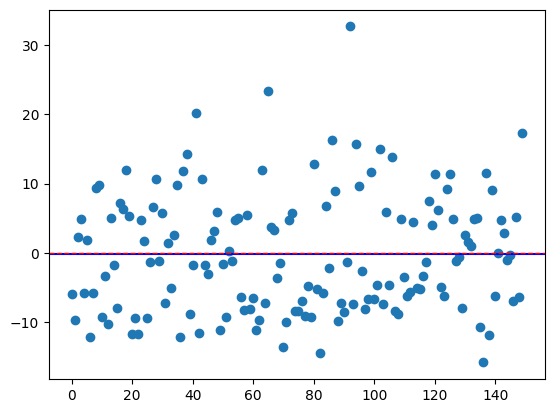

In [ ]:
xb = xBartDiric(Xpd, Ypd_t, 2, 0.1, 3)
xb.init_xbart()
xb.burn_in(100)

plt.scatter(np.arange(len(xb.residual)), xb.residual)
plt.axline((0,xb.residual.mean()),slope=0, color='blue')
plt.axline((0,0),slope=0, color='red', linestyle='--', linewidth=1);

In [18]:
pred, mu, sigma, pi = xb.mcmc(50)

In [19]:
sd = np.sqrt(sigma)
clust_ci = np.concatenate((mu+sd*2.5, mu-sd*2.5))
post_pdf_x_grid = np.linspace(clust_ci.min(), clust_ci.max(), 100)

post_pdf_y_grid = posterior_pdf(post_pdf_x_grid, mu, sigma, pi)
post_pdf_ci = np.quantile(post_pdf_y_grid, [0.025, 0.975], axis=0)
post_pdf_mean = post_pdf_y_grid.mean(axis=0)

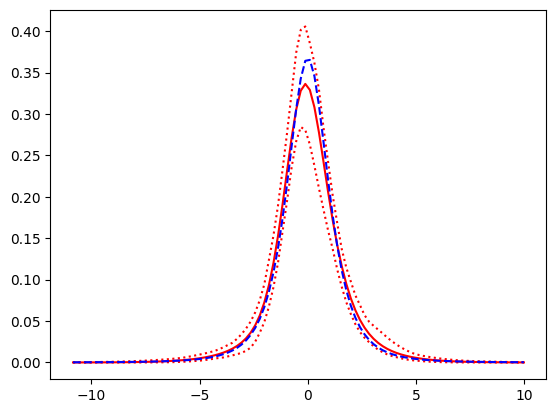

In [20]:
plt.plot(post_pdf_x_grid, post_pdf_mean, 'r-', post_pdf_x_grid, post_pdf_ci[0,:], 'r:', post_pdf_x_grid, post_pdf_ci[1,:], 'r:',
         post_pdf_x_grid, sstat.t.pdf(post_pdf_x_grid, df=3), 'b--');

##### centered gamma(3, 5)

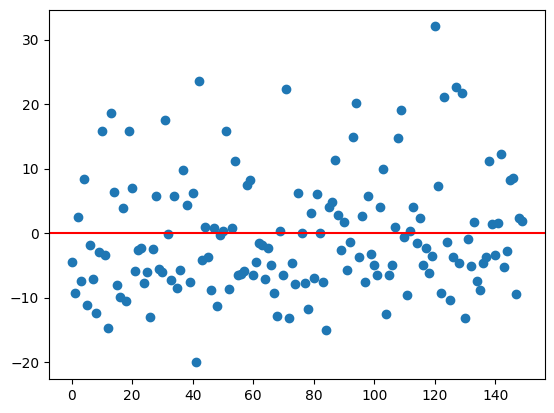

In [37]:
Ypd_gam = pd.Series(iris_data.target*3+np.random.gamma(shape=3, scale=5, size=len(iris_data.target))-15)

xb = xBartDiric(Xpd, Ypd_gam, 2, 0.4, 3)
xb.init_xbart()
xb.burn_in(100)

plt.scatter(np.arange(len(xb.residual)), xb.residual)
plt.axline((0,0),slope=0, color='red');

In [ ]:
pred, mu, sigma, pi = xb.mcmc(50)

In [ ]:
sd = np.sqrt(sigma)
clust_ci = np.concatenate((mu+sd*2.5, mu-sd*2.5))
#post_pdf_x_grid = np.linspace(clust_ci.min(), clust_ci.max(), 100)
post_pdf_x_grid = np.linspace(-40, 45, 100)

post_pdf_y_grid = posterior_pdf(post_pdf_x_grid, mu, sigma, pi)
post_pdf_ci = np.quantile(post_pdf_y_grid, [0.025, 0.975], axis=0)
post_pdf_mean = post_pdf_y_grid.mean(axis=0)

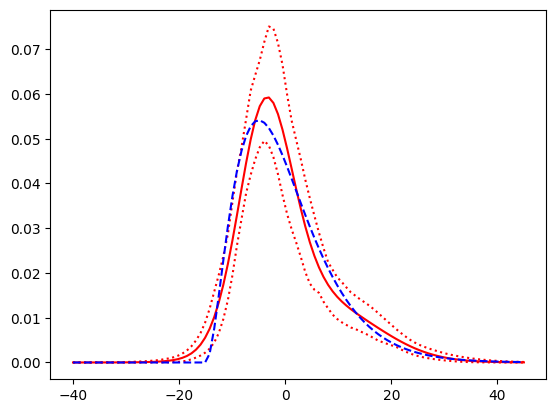

In [46]:
plt.plot(post_pdf_x_grid, post_pdf_mean, 'r-', post_pdf_x_grid, post_pdf_ci[0,:], 'r:', post_pdf_x_grid, post_pdf_ci[1,:], 'r:',
         post_pdf_x_grid, sstat.gamma.pdf(post_pdf_x_grid+15, a=3, scale=5), 'b--');